# Day 2: Fama-French 3-Factor Model

---

### 🎯 Learning Objectives
- Understand the Fama-French 3-Factor Model
- Calculate SMB (Small Minus Big) and HML (High Minus Low) factors
- Run multi-factor regressions
- Compare model performance with CAPM


---| Miss size/value risks | Captures systematic risks |

| "Alpha" may be factor exposure | True alpha identified |

### 📈 Why Fama-French 3-Factor Matters| R² ~ 70% | R² ~ 90% |

|----------------|----------|

**CAPM's single factor doesn't explain everything.** FF3 adds Size and Value.| With CAPM Only | With FF3 |



### Key Formula### Why Add Factors?

$$R_i - R_f = \alpha_i + \beta_i^M(R_m - R_f) + \beta_i^{SMB}SMB + \beta_i^{HML}HML + \epsilon_i$$

| Low factor βs | Closer to market exposure only |

### The Three Factors| High HML β | Tilted toward value stocks |

| High SMB β | Tilted toward small caps |

| Factor | Full Name | What It Captures ||----------------|-------------------------|

|--------|-----------|------------------|| Factor Loading | Portfolio Characteristic |

| **MKT** | Market | Equity risk premium |

| **SMB** | Small Minus Big | Size effect (small outperforms) |### Trading Applications

| **HML** | High Minus Low | Value effect (cheap outperforms) |

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Constants
TRADING_DAYS = 252  # Trading days per year
RISK_FREE_RATE = 0.05  # Risk-free rate (5%)

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1256 days


## 1. Construct Proxy Factors

### 🎯 Building Factor Portfolios

| Build your own | From fundamental data |

Since we don't have actual FF factors, we'll construct proxies from our data.| Bloomberg | Factor indices |

| MSCI Barra | Commercial factor data |

### How Factors Are Constructed| Kenneth French's website | Official FF factors (free) |

|--------|-------------|

| Factor | Long Leg | Short Leg | Return || Source | Description |

|--------|----------|-----------|--------|

| **SMB** | Small caps | Large caps | Small - Big |### Real-World Factor Sources

| **HML** | High B/M (value) | Low B/M (growth) | Value - Growth |

In [7]:
# Define stock characteristics (market cap proxy)
# Using volatility as a proxy for size (small caps tend to be more volatile)
volatilities = returns.std()

# Classify stocks as Small or Big based on volatility
median_vol = volatilities.median()
small_stocks = volatilities[volatilities > median_vol].index.tolist()
big_stocks = volatilities[volatilities <= median_vol].index.tolist()

# Remove market proxy from lists
if 'AAPL' in small_stocks:
    small_stocks.remove('AAPL')
if 'AAPL' in big_stocks:
    big_stocks.remove('AAPL')

print(f"Small-cap proxies ({len(small_stocks)} stocks): {small_stocks[:5]}...")
print(f"Big-cap proxies ({len(big_stocks)} stocks): {big_stocks[:5]}...")

# Construct SMB factor
small_returns = returns[small_stocks].mean(axis=1)
big_returns = returns[big_stocks].mean(axis=1)
SMB = small_returns - big_returns

print(f"\nSMB Factor Statistics:")
print(f"   Mean (annual): {SMB.mean() * TRADING_DAYS:.2%}")
print(f"   Volatility (annual): {SMB.std() * np.sqrt(TRADING_DAYS):.2%}")

Small-cap proxies (1 stocks): ['GOOGL']...
Big-cap proxies (3 stocks): ['GS', 'JPM', 'MSFT']...

SMB Factor Statistics:
   Mean (annual): 6.60%
   Volatility (annual): 26.16%


In [8]:
# Construct HML factor using momentum as proxy for value
# (In practice, you'd use book-to-market ratios)

# Use past 6-month returns to classify
past_returns = returns.rolling(126).mean().iloc[-1]

# Value = low momentum (beaten down), Growth = high momentum
median_ret = past_returns.median()
value_stocks = past_returns[past_returns < median_ret].index.tolist()
growth_stocks = past_returns[past_returns >= median_ret].index.tolist()

# Remove market proxy
if 'AAPL' in value_stocks:
    value_stocks.remove('AAPL')
if 'AAPL' in growth_stocks:
    growth_stocks.remove('AAPL')

print(f"Value proxies ({len(value_stocks)} stocks): {value_stocks[:5]}...")
print(f"Growth proxies ({len(growth_stocks)} stocks): {growth_stocks[:5]}...")

# Construct HML factor (High B/M minus Low B/M)
value_returns = returns[value_stocks].mean(axis=1)
growth_returns = returns[growth_stocks].mean(axis=1)
HML = value_returns - growth_returns

print(f"\nHML Factor Statistics:")
print(f"   Mean (annual): {HML.mean() * TRADING_DAYS:.2%}")
print(f"   Volatility (annual): {HML.std() * np.sqrt(TRADING_DAYS):.2%}")

Value proxies (2 stocks): ['JPM', 'MSFT']...
Growth proxies (2 stocks): ['GOOGL', 'GS']...

HML Factor Statistics:
   Mean (annual): -9.75%
   Volatility (annual): 15.44%


In [9]:
# Market factor
market_returns = returns['AAPL']
daily_rf = RISK_FREE_RATE / TRADING_DAYS
MKT = market_returns - daily_rf

# Combine factors
factors = pd.DataFrame({
    'MKT': MKT,
    'SMB': SMB,
    'HML': HML
}).dropna()

print("\n" + "="*60)
print("FACTOR CORRELATION MATRIX")
print("="*60)
print(factors.corr().round(4))

print("\n💡 Ideal: Low correlations between factors (orthogonal risk sources)")


FACTOR CORRELATION MATRIX
        MKT     SMB     HML
MKT  1.0000  0.2270 -0.1392
SMB  0.2270  1.0000 -0.5906
HML -0.1392 -0.5906  1.0000

💡 Ideal: Low correlations between factors (orthogonal risk sources)


## 2. Run 3-Factor Regression

In [10]:
def run_ff3_regression(stock_returns, factors, daily_rf):
    """Run Fama-French 3-Factor regression."""
    excess_returns = stock_returns - daily_rf
    
    # Align data
    aligned = pd.concat([excess_returns, factors], axis=1).dropna()
    y = aligned.iloc[:, 0]
    X = sm.add_constant(aligned[['MKT', 'SMB', 'HML']])
    
    model = sm.OLS(y, X).fit()
    return model

# Run regression for test stocks
test_stocks = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']

print("\n" + "="*70)
print("FAMA-FRENCH 3-FACTOR REGRESSION RESULTS")
print("="*70)
print(f"{'Stock':<8} {'Alpha':<10} {'β_MKT':<10} {'β_SMB':<10} {'β_HML':<10} {'R²':<8}")
print("-"*70)

ff3_results = []
for stock in test_stocks:
    if stock in returns.columns:
        model = run_ff3_regression(returns[stock], factors, daily_rf)
        
        result = {
            'stock': stock,
            'alpha': model.params['const'] * TRADING_DAYS,
            'beta_mkt': model.params['MKT'],
            'beta_smb': model.params['SMB'],
            'beta_hml': model.params['HML'],
            'r2': model.rsquared
        }
        ff3_results.append(result)
        
        print(f"{stock:<8} {result['alpha']:<10.4%} {result['beta_mkt']:<10.4f} "
              f"{result['beta_smb']:<10.4f} {result['beta_hml']:<10.4f} {result['r2']:<8.4f}")

ff3_df = pd.DataFrame(ff3_results)


FAMA-FRENCH 3-FACTOR REGRESSION RESULTS
Stock    Alpha      β_MKT      β_SMB      β_HML      R²      
----------------------------------------------------------------------
AAPL     0.0000%    1.0000     0.0000     0.0000     1.0000  
MSFT     11.4646%   0.5717     0.2642     0.5969     0.4796  
GOOGL    12.1470%   0.4808     0.6423     -0.3599    0.7508  
JPM      12.8293%   0.3900     -0.4796    -0.3167    0.3027  
GS       12.1470%   0.4808     -0.8577    -1.3599    0.6788  


## 3. Compare with CAPM

In [16]:
def run_capm_regression(stock_returns, market_returns, daily_rf):
    """Run CAPM regression."""
    excess_stock = stock_returns - daily_rf
    excess_market = market_returns - daily_rf
    
    X = sm.add_constant(excess_market)
    model = sm.OLS(excess_stock, X).fit()
    return model

print("\n" + "="*60)
print("MODEL COMPARISON: CAPM vs FF3")
print("="*60)
print(f"{'Stock':<8} {'CAPM R²':<12} {'FF3 R²':<12} {'Improvement':<12}")
print("-"*60)

comparisons = []
for stock in test_stocks:
    if stock in returns.columns:
        capm = run_capm_regression(returns[stock], market_returns, daily_rf)
        ff3 = run_ff3_regression(returns[stock], factors, daily_rf)
        
        improvement = ff3.rsquared - capm.rsquared
        
        comparisons.append({
            'stock': stock,
            'capm_r2': capm.rsquared,
            'ff3_r2': ff3.rsquared,
            'improvement': improvement
        })
        
        print(f"{stock:<8} {capm.rsquared:<12.4f} {ff3.rsquared:<12.4f} {improvement:<12.4f}")

print("\n💡 Higher R² means more return variation explained by the model")


MODEL COMPARISON: CAPM vs FF3
Stock    CAPM R²      FF3 R²       Improvement 
------------------------------------------------------------
AAPL     1.0000       1.0000       0.0000      
MSFT     0.3927       0.4796       0.0868      
GOOGL    0.3327       0.7508       0.4181      
JPM      0.1261       0.3027       0.1766      
GS       0.1660       0.6788       0.5129      

💡 Higher R² means more return variation explained by the model


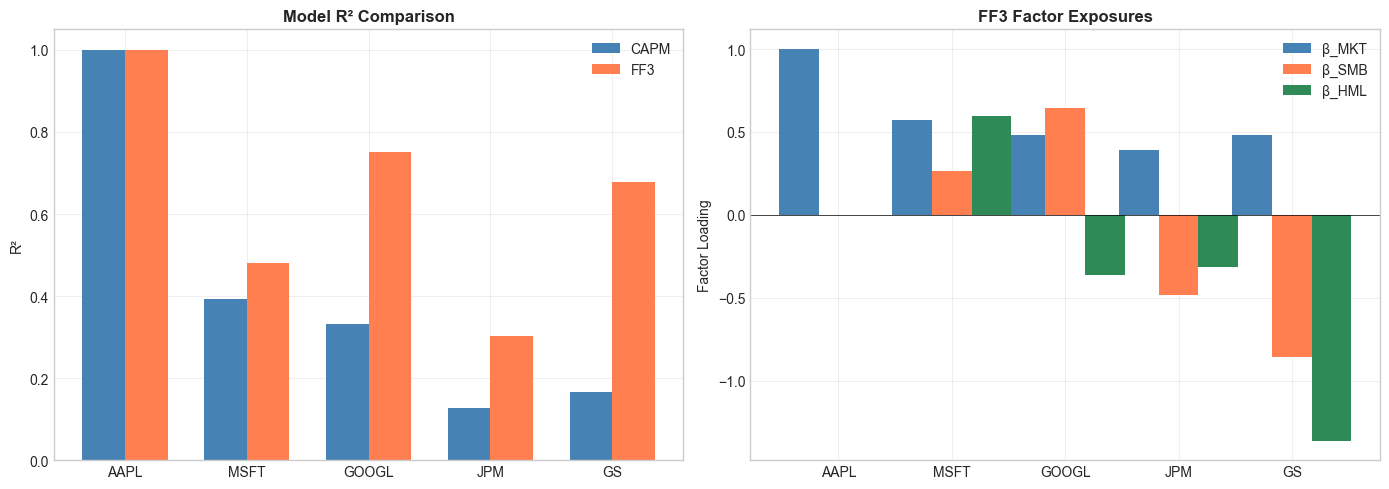

In [17]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

comp_df = pd.DataFrame(comparisons)

# R² Comparison
x = np.arange(len(test_stocks))
width = 0.35

ax1 = axes[0]
ax1.bar(x - width/2, comp_df['capm_r2'], width, label='CAPM', color='steelblue')
ax1.bar(x + width/2, comp_df['ff3_r2'], width, label='FF3', color='coral')
ax1.set_xticks(x)
ax1.set_xticklabels(comp_df['stock'])
ax1.set_ylabel('R²')
ax1.set_title('Model R² Comparison', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Factor Loadings
ax2 = axes[1]
ax2.bar(x - width, ff3_df['beta_mkt'], width, label='β_MKT', color='steelblue')
ax2.bar(x, ff3_df['beta_smb'], width, label='β_SMB', color='coral')
ax2.bar(x + width, ff3_df['beta_hml'], width, label='β_HML', color='seagreen')
ax2.set_xticks(x)
ax2.set_xticklabels(ff3_df['stock'])
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_ylabel('Factor Loading')
ax2.set_title('FF3 Factor Exposures', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Alpha Analysis

In [18]:
print("="*70)
print("ALPHA SIGNIFICANCE: CAPM vs FF3")
print("="*70)
print(f"{'Stock':<8} {'CAPM α':<12} {'CAPM p-val':<12} {'FF3 α':<12} {'FF3 p-val':<12}")
print("-"*70)

for stock in test_stocks:
    if stock in returns.columns:
        capm = run_capm_regression(returns[stock], market_returns, daily_rf)
        ff3 = run_ff3_regression(returns[stock], factors, daily_rf)
        
        capm_alpha = capm.params.iloc[0] * TRADING_DAYS
        capm_pval = capm.pvalues.iloc[0]
        ff3_alpha = ff3.params['const'] * TRADING_DAYS
        ff3_pval = ff3.pvalues['const']
        
        print(f"{stock:<8} {capm_alpha:<12.4%} {capm_pval:<12.4f} {ff3_alpha:<12.4%} {ff3_pval:<12.4f}")

print("\n💡 Alpha often decreases from CAPM to FF3")
print("   - CAPM alpha may be 'false alpha' due to factor exposure")
print("   - FF3 provides a more complete picture of return sources")

ALPHA SIGNIFICANCE: CAPM vs FF3
Stock    CAPM α       CAPM p-val   FF3 α        FF3 p-val   
----------------------------------------------------------------------
AAPL     0.0000%      0.2456       0.0000%      0.0000      
MSFT     7.2785%      0.4178       11.4646%     0.1688      
GOOGL    18.1654%     0.1102       12.1470%     0.0810      
JPM      13.5701%     0.1828       12.8293%     0.1593      
GS       20.5686%     0.0663       12.1470%     0.0810      

💡 Alpha often decreases from CAPM to FF3
   - CAPM alpha may be 'false alpha' due to factor exposure
   - FF3 provides a more complete picture of return sources


## 5. Factor Return Analysis

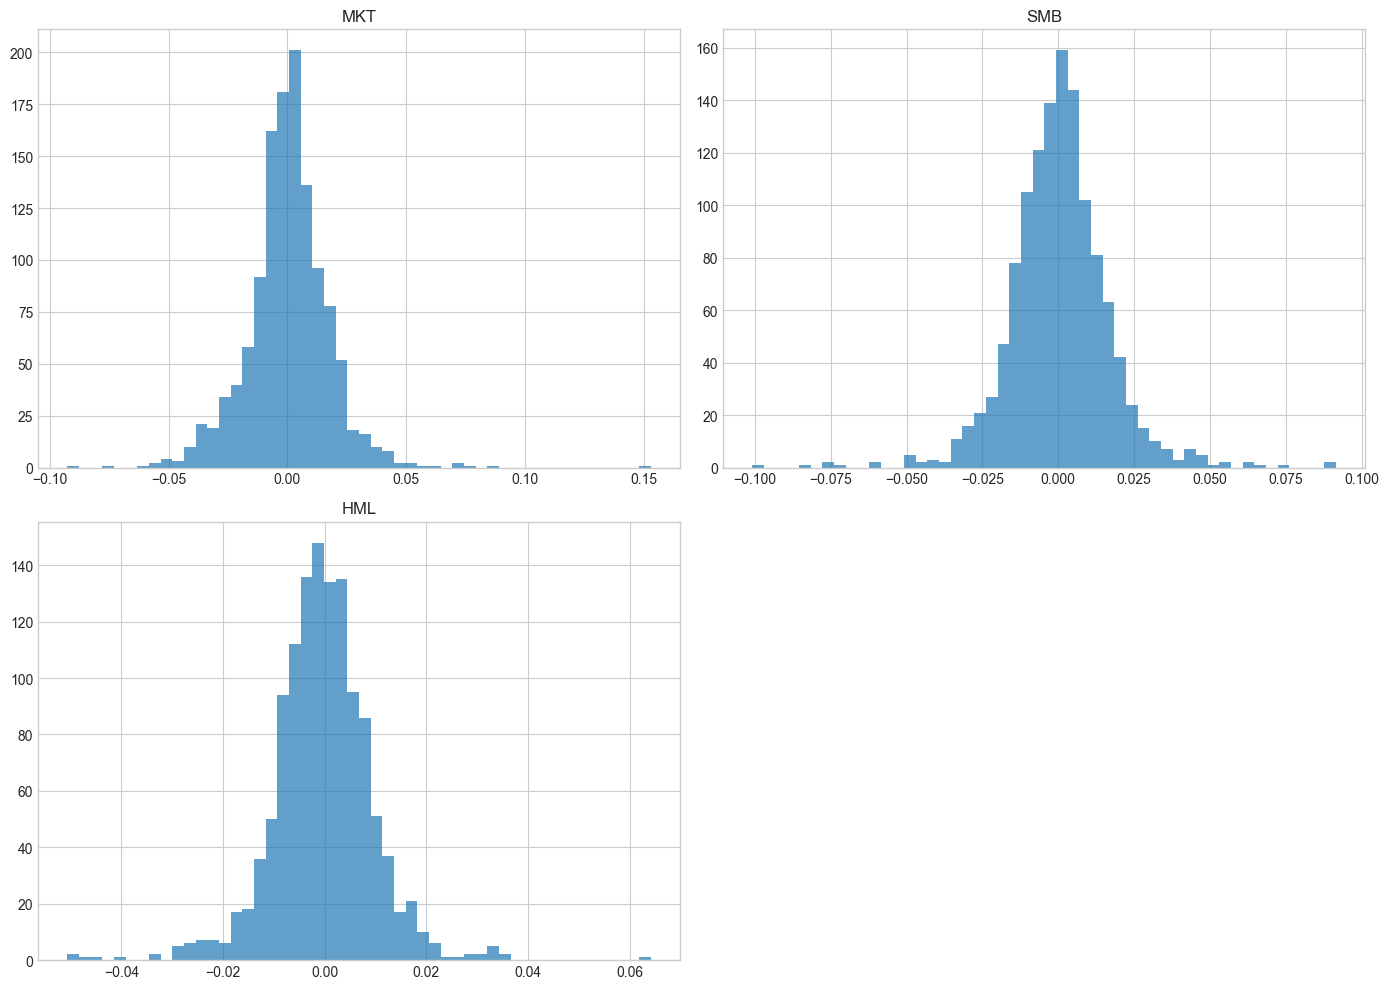


📊 Factor Statistics Summary:
     Mean (Ann.)  Vol (Ann.)  Sharpe
MKT       0.1042      0.2767  0.3766
SMB       0.0660      0.2616  0.2521
HML      -0.0975      0.1544 -0.6318


In [19]:
# Cumulative factor returns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative returns
ax1 = axes[0, 0]
cum_mkt = (1 + factors['MKT']).cumprod()
cum_smb = (1 + factors['SMB']).cumprod()
cum_hml = (1 + factors['HML']).cumprod()

ax1.plot(cum_mkt, label='Market', linewidth=2)
ax1.plot(cum_smb, label='SMB', linewidth=2)
ax1.plot(cum_hml, label='HML', linewidth=2)
ax1.set_title('Cumulative Factor Returns', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylabel('Cumulative Return')

# Rolling Sharpe
ax2 = axes[0, 1]
window = 60
for col in ['MKT', 'SMB', 'HML']:
    rolling_sharpe = (factors[col].rolling(window).mean() / 
                      factors[col].rolling(window).std() * np.sqrt(TRADING_DAYS))
    ax2.plot(rolling_sharpe, label=col)
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Rolling 60-Day Sharpe Ratio', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Distribution
ax3 = axes[1, 0]
factors.hist(bins=50, ax=ax3, alpha=0.7)
ax3.set_title('Factor Return Distributions', fontweight='bold')

# Factor statistics
ax4 = axes[1, 1]
stats_df = pd.DataFrame({
    'Mean (Ann.)': factors.mean() * TRADING_DAYS,
    'Vol (Ann.)': factors.std() * np.sqrt(TRADING_DAYS),
    'Sharpe': (factors.mean() * TRADING_DAYS) / (factors.std() * np.sqrt(TRADING_DAYS))
})
stats_df.plot(kind='bar', ax=ax4)
ax4.set_title('Factor Statistics', fontweight='bold')
ax4.legend(loc='upper right')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\n📊 Factor Statistics Summary:")
print(stats_df.round(4))

## Key Takeaways

1. **Fama-French 3-Factor** adds Size (SMB) and Value (HML) to CAPM
2. **SMB** captures small-cap premium
3. **HML** captures value premium
4. **Higher R²** than CAPM - explains more return variation
5. **Alpha often decreases** when accounting for additional factors

---
*Next: Day 3 - Fama-French 5-Factor Model*

## 🔴 PROS & CONS: FF3 Factor

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [20]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - FF3 Factor Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-24 10:51

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $248.04
   GOOGL: $327.93
   GS: $918.88
   JPM: $297.72
   MSFT: $465.95

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -9.41%
   🟢 GOOGL: +4.41%
   🟢 GS: +0.89%
   🔴 JPM: -9.15%
   🔴 MSFT: -4.52%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟡 NEUTRAL - Hold current positions
   GS: 🟡 NEUTRAL - Hold current positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🟡 NEUTRAL - Hold current positions

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
